## **Note!**

Make sure you install pygame in your terminal: \
pip install pygame

## **Prototype 5 - Items**

There are items in this game now:
1. There is an item that can make agent's move 1.5 faster for at least 2 seconds and then back to normal (item is rectangle-orange)
2. There is an item that can make agent's move 1.5 slower for at least 2 seconds and then back to normal (item is rectangle-red)
3. We need to disable the projected path by default. So, we don't need the "P" button to turn it on and off. There is an item that can show the projected path for at least 2 seconds (item is rectangle-purple).

**To test it, run the code**

In [ ]:
import pygame
import sys
import random
import heapq
from datetime import datetime, timedelta
from collections import deque

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
ORANGE = (255, 165, 0)
GREY = (200, 200, 200)

# Constants
WIDTH, HEIGHT = 800, 600
CELL_SIZE = 20
COLS = 100  # Expanded horizontally
ROWS = HEIGHT // CELL_SIZE
AGENT_SPEED = 200  # pixels per second
MIN_DISTANCE = COLS // 4  # Minimum distance between start and end
ITEM_TYPES = {
    'speed_up': {'color': ORANGE, 'effect': 1.5, 'duration': 2},
    'speed_down': {'color': RED, 'effect': 0.67, 'duration': 2},
    'reveal_path': {'color': (128, 0, 128), 'effect': True, 'duration': 2}
}
ITEM_SPACING = 3  # Minimum cells between items
NUM_ITEMS = 15      # Total items to spawn
ITEM_SCALE = 0.6

# Camera control
camera_x = 0
CAMERA_LERP = 0.1
CAMERA_OFFSET = WIDTH // 4  # Agent appears 25% from left
MAX_CAMERA_X = (COLS * CELL_SIZE) - WIDTH

class Item:
    def __init__(self, pos, item_type):
        self.grid_pos = pos  # (row, col)
        self.screen_pos = (pos[1]*CELL_SIZE + CELL_SIZE//2,
                         pos[0]*CELL_SIZE + CELL_SIZE//2)
        self.type = item_type
        self.active = True

    def check_item_collision(agent_pos, items):
        agent_rect = pygame.Rect(
            agent_pos.x - CELL_SIZE//4,
            agent_pos.y - CELL_SIZE//4,
            CELL_SIZE//2,
            CELL_SIZE//2
        )

        for idx, item in enumerate(items):
            if not item.active:
                continue

            # Smaller collision box for items
            item_width = CELL_SIZE * ITEM_SCALE
            item_rect = pygame.Rect(
                item.screen_pos[0] - item_width//2,  # Centered
                item.screen_pos[1] - item_width//2,
                item_width,
                item_width
            )

            if agent_rect.colliderect(item_rect):
                item.active = False
                return item
        return None

class SmoothAgent:
    def __init__(self, start_pos):
        self.target_pos = start_pos
        self.current_pos = pygame.Vector2(
            start_pos[1] * CELL_SIZE + CELL_SIZE/2,
            start_pos[0] * CELL_SIZE + CELL_SIZE/2
        )
        self.speed = AGENT_SPEED
        self.moving = False
        self.base_speed = AGENT_SPEED
        self.speed = AGENT_SPEED
        self.active_effects = deque(maxlen=3)

    def update(self, path, dt):
        if not path or self.current_pos == self.target_pos:
            return

        target_x = self.target_pos[1] * CELL_SIZE + CELL_SIZE/2
        target_y = self.target_pos[0] * CELL_SIZE + CELL_SIZE/2

        direction = pygame.Vector2(target_x - self.current_pos.x,
                                 target_y - self.current_pos.y)
        if direction.length() > 0:
            direction.scale_to_length(self.speed * dt)
            self.current_pos += direction

            if (self.current_pos - pygame.Vector2(target_x, target_y)).length() < 2:
                self.current_pos = pygame.Vector2(target_x, target_y)

from collections import deque

def bfs_reachable(maze, start):
    visited = set()
    queue = deque([start])
    visited.add(start)
    directions = [(-1,0), (1,0), (0,-1), (0,1)]

    while queue:
        current = queue.popleft()
        for dx, dy in directions:
            nx, ny = current[0] + dx, current[1] + dy
            if 0 <= nx < ROWS and 0 <= ny < COLS:
                if maze[nx][ny] == 0 and (nx, ny) not in visited:
                    visited.add((nx, ny))
                    queue.append((nx, ny))
    return visited

def get_valid_path_cells(maze, start, end):
    from_start = bfs_reachable(maze, start)
    from_end = bfs_reachable(maze, end)
    return from_start.intersection(from_end)  # Cells in both BFS results

def generate_items(maze, start, end):
    valid_cells = get_valid_path_cells(maze, start, end)
    valid_positions = [c for c in valid_cells if c != start and c != end]
    items = []

    # Randomize selection with spacing
    random.shuffle(valid_positions)
    for pos in valid_positions:
        if len(items) >= NUM_ITEMS:
            break
        if all(
            abs(pos[0]-i.grid_pos[0]) >= ITEM_SPACING and
            abs(pos[1]-i.grid_pos[1]) >= ITEM_SPACING
            for i in items
        ):
            item_type = random.choice(list(ITEM_TYPES.keys()))
            items.append(Item(pos, item_type))
    return items

def check_item_collision(agent_pos, items):
    agent_rect = pygame.Rect(
        agent_pos.x - CELL_SIZE//4,
        agent_pos.y - CELL_SIZE//4,
        CELL_SIZE//2,
        CELL_SIZE//2
    )

    for idx, item in enumerate(items):
        if not item.active:
            continue

        item_rect = pygame.Rect(
            item.screen_pos[0] - CELL_SIZE//4,
            item.screen_pos[1] - CELL_SIZE//4,
            CELL_SIZE//2,
            CELL_SIZE//2
        )

        if agent_rect.colliderect(item_rect):
            item.active = False
            return item
    return None

def generate_maze(rows, cols):
    # Ensure start and end positions meet distance requirement
    while True:
        maze = [[1 for _ in range(cols)] for _ in range(rows)]
        start = (random.randint(0, rows-1), random.randint(0, cols//8))
        end = (random.randint(0, rows-1), random.randint(cols - cols//8, cols-1))

        if abs(start[1] - end[1]) < MIN_DISTANCE:
            continue

        stack = [start]
        maze[start[0]][start[1]] = 0
        directions = [(-1,0),(1,0),(0,-1),(0,1)]

        while stack:
            current = stack[-1]
            neighbors = []
            for dx, dy in directions:
                nx, ny = current[0]+dx*2, current[1]+dy*2
                if 0 <= nx < rows and 0 <= ny < cols and maze[nx][ny] == 1:
                    neighbors.append((nx, ny))

            if neighbors:
                next_cell = random.choice(neighbors)
                wall = (current[0]+(next_cell[0]-current[0])//2,
                        current[1]+(next_cell[1]-current[1])//2)
                maze[wall[0]][wall[1]] = 0
                maze[next_cell[0]][next_cell[1]] = 0
                stack.append(next_cell)
            else:
                stack.pop()

        # Add horizontal paths
        for _ in range(cols * 2):
            x, y = random.randint(0, rows-1), random.randint(0, cols-1)
            maze[x][y] = 0

        if astar(maze, start, end):
            return maze, start, end

# A* Pathfinding Algorithm
def astar(maze, start, end):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = { (r, c): float('inf') for r in range(ROWS) for c in range(COLS) }
    g_score[start] = 0
    f_score = { (r, c): float('inf') for r in range(ROWS) for c in range(COLS) }
    f_score[start] = heuristic(start, end)

    while open_set:
        current = heapq.heappop(open_set)[1]

        if current == end:
            return reconstruct_path(came_from, current)

        for neighbor in get_neighbors(maze, current):
            tentative_g = g_score[current] + 1
            if tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + heuristic(neighbor, end)
                if neighbor not in [i[1] for i in open_set]:
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def get_neighbors(maze, pos):
    neighbors = []
    for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
        nx, ny = pos[0]+dx, pos[1]+dy
        if 0 <= nx < ROWS and 0 <= ny < COLS:
            if maze[nx][ny] == 0:
                neighbors.append((nx, ny))
    return neighbors

def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    return path[::-1]

def draw_text(surface, text, pos, size=30, color=BLACK):
    font = pygame.font.SysFont(None, size)
    text_surface = font.render(text, True, color)
    surface.blit(text_surface, pos)

def update_camera(dt):
    global camera_x
    target_x = agent.current_pos.x - CAMERA_OFFSET
    target_x = max(0, min(target_x, MAX_CAMERA_X))
    camera_x += (target_x - camera_x) * CAMERA_LERP * dt * 60

# Initialize Pygame
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Mega Maze Pathfinder")

# Generate initial maze
maze, start, end = generate_maze(ROWS, COLS)
valid_cells = get_valid_path_cells(maze, start, end)
path = astar(maze, start, end)
items = generate_items(maze, start, end)
show_path = False  # Default to hidden
original_maze = [row[:] for row in maze]
agent = SmoothAgent(start)
game_over = False
show_path = True
last_block_time = datetime.now()
block_cooldown = 2  # seconds
path_index = 0
clock = pygame.time.Clock()

while True:
    dt = clock.tick(60)/1000
    time_since_last_block = datetime.now() - last_block_time
    can_place_block = time_since_last_block.total_seconds() >= block_cooldown

    # Event handling
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()
            sys.exit()

        elif event.type == pygame.MOUSEBUTTONDOWN and not game_over and can_place_block:
            mx, my = pygame.mouse.get_pos()
            world_x = mx + camera_x
            col = int(world_x // CELL_SIZE)
            row = int(my // CELL_SIZE)

            if 0 <= row < ROWS and 0 <= col < COLS:
                if event.button == 1:  # Add block
                    if maze[row][col] == 0 and (row, col) != start and (row, col) != end:
                        maze[row][col] = 1
                        last_block_time = datetime.now()
                elif event.button == 3:  # Remove block
                    if maze[row][col] == 1:
                        maze[row][col] = 0
                        last_block_time = datetime.now()

                # Recalculate path
                current_grid = (
                    int(agent.current_pos.y // CELL_SIZE),
                    int(agent.current_pos.x // CELL_SIZE)
                )
                new_path = astar(maze, current_grid, end)
                if new_path:
                    path = new_path
                    path_index = 0
                    agent.target_pos = path[path_index]
                else:
                    game_over = True

        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_r:  # Reset current maze
                maze = [row[:] for row in original_maze]
                path = astar(maze, start, end)
                items = generate_items(maze, start, end)
                game_over = False
                path_index = 0
                agent = SmoothAgent(start)
                camera_x = 0
            elif event.key == pygame.K_t:  # New maze
                maze, start, end = generate_maze(ROWS, COLS)
                original_maze = [row[:] for row in maze]
                path = astar(maze, start, end)
                items = generate_items(maze, start, end)
                game_over = False
                path_index = 0
                agent = SmoothAgent(start)
                camera_x = 0

    # Agent movement
    if path and not game_over and path_index < len(path):
        agent.target_pos = path[path_index]
        if agent.current_pos.distance_to(
            (agent.target_pos[1]*CELL_SIZE + CELL_SIZE/2,
             agent.target_pos[0]*CELL_SIZE + CELL_SIZE/2)
        ) < 2:
            path_index += 1

    agent.update(path, dt)
    update_camera(dt)

    # Item effect expiration check
    current_time = datetime.now()
    while agent.active_effects and (current_time - agent.active_effects[0]['start_time']).total_seconds() > agent.active_effects[0]['duration']:
        expired = agent.active_effects.popleft()
        if expired['type'] == 'speed':
            agent.speed = agent.base_speed

    # Item collision check
    collided_item = check_item_collision(agent.current_pos, items)
    if collided_item:
        effect_info = ITEM_TYPES[collided_item.type]

        if 'speed' in collided_item.type:
            agent.speed = agent.base_speed * effect_info['effect']
            agent.active_effects.append({
                'type': 'speed',
                'start_time': datetime.now(),
                'duration': effect_info['duration']
            })
        elif collided_item.type == 'reveal_path':
            show_path = True
            agent.active_effects.append({
                'type': 'path',
                'start_time': datetime.now(),
                'duration': effect_info['duration']
            })

    # Update path visibility
    path_effect = next((e for e in agent.active_effects if e['type'] == 'path'), None)
    show_path = path_effect is not None

    # Drawing
    screen.fill(WHITE)

    # Visible columns
    start_col = int(camera_x // CELL_SIZE)
    end_col = start_col + (WIDTH // CELL_SIZE) + 2

    # Draw maze
    for r in range(ROWS):
        for c in range(max(0, start_col), min(COLS, end_col)):
            if maze[r][c] == 1:
                pygame.draw.rect(screen, BLACK,
                               (c*CELL_SIZE - camera_x, r*CELL_SIZE, CELL_SIZE, CELL_SIZE))

    # Start/End points
    pygame.draw.rect(screen, GREEN,
                   (start[1]*CELL_SIZE - camera_x, start[0]*CELL_SIZE, CELL_SIZE, CELL_SIZE))
    pygame.draw.rect(screen, BLUE,
                   (end[1]*CELL_SIZE - camera_x, end[0]*CELL_SIZE, CELL_SIZE, CELL_SIZE))

    # Projected path
    if show_path and path and not game_over and path_index < len(path):
        for p in path[path_index:]:
            pygame.draw.circle(screen, ORANGE,
                             (p[1]*CELL_SIZE - camera_x + CELL_SIZE//2,
                              p[0]*CELL_SIZE + CELL_SIZE//2),
                             2)

    # Agent
    pygame.draw.circle(screen, RED,
                     (agent.current_pos.x - camera_x,
                      agent.current_pos.y),
                     CELL_SIZE//3)

    for item in items:
        if item.active:
            color = ITEM_TYPES[item.type]['color']
            item_size = CELL_SIZE * ITEM_SCALE
            offset = (CELL_SIZE - item_size) // 2  # Center in cell
            pygame.draw.rect(screen, color, (
                item.grid_pos[1]*CELL_SIZE - camera_x + offset,
                item.grid_pos[0]*CELL_SIZE + offset,
                item_size,
                item_size
            ))

    # UI
    if not can_place_block:
        remaining = block_cooldown - time_since_last_block.total_seconds()
        draw_text(screen, f"Block Cooldown: {remaining:.1f}s", (10, HEIGHT-40), 30, RED)
    else:
        draw_text(screen, "Ready to place blocks", (10, HEIGHT-40), 30, GREEN)

    if game_over:
        draw_text(screen, "All paths blocked!", (WIDTH//2-100, HEIGHT//2-20), 40, RED)
        draw_text(screen, "R: Restart  T: New Maze", (WIDTH//2-120, HEIGHT//2+20), 30)

    pygame.display.flip()

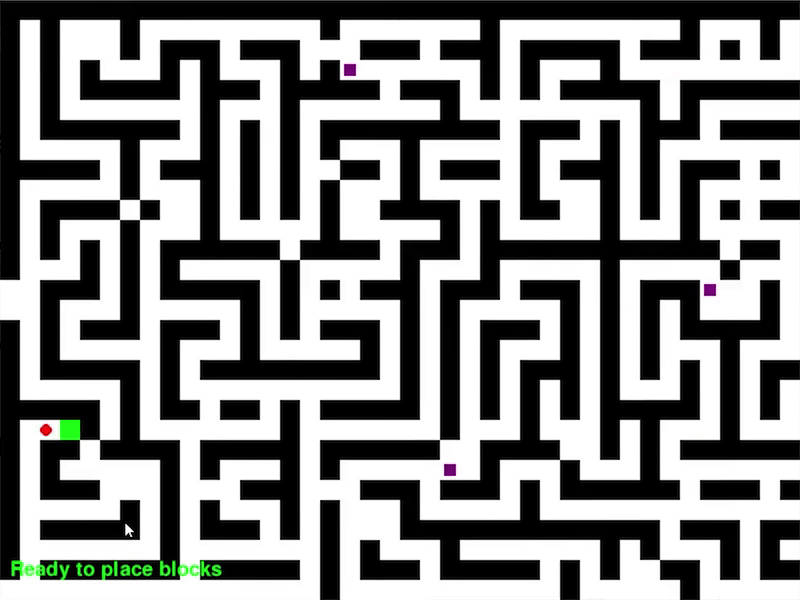